# AutoGenU for Jupyter

An Automatic C++ Code Generator for Nonlinear Model Predictive Control (NMPC)

---


## Formulation of the trajectory following problem: Ackermann Steering Geometry


### Model description

<div style="background-color:white;">
    <img src="./vehicle_error_kinematics.drawio.svg" width=80%>
</div>

The above figure shows the model of a cart pole. By the Lagrange's method, the equation of the motion is derived as

\begin{align}\frac{dy}{dt} &= v \sin \theta \\
\frac{d\theta}{dt} &= \frac{v \tan \delta}{L} - \kappa*r v \cos \theta \\
\frac{d\delta}{dt} &= -\frac{1}{\tau} (\delta - \delta*{des})\end{align}

We also assume that the input of the cartpole is limited as  
$$u_{\rm min} \leq u \leq u_{\rm max} , $$
where $u_{\rm min}, u_{\rm max} \in \mathbb{R}$.

---

### Formulation of the optimal control problem

We define the state vector as
$$ x = \begin{bmatrix} y \\ \theta \\ \delta \end{bmatrix} .$$

The state equation is then given as

$$
\dot{x} = f(t, x, u) = \begin{bmatrix}
v \sin \theta \\
\frac{v \tan \delta}{L} - \kappa_r v \cos \theta \\
-\frac{1}{\tau} (\delta - \delta_{\text{des}})
\end{bmatrix}.
$$

Next, we set the cost function
$$ J = \varphi(t, x) + \int\_{t}^{t+T} L(t, x, u) .$$

The objective is to invert the pole and stabilize the cart around $y=0$. In other words, we want to converge the state of the cart pole to
$$x_{\rm ref} := \begin{bmatrix} 0 \\ 0 \\ \delta_r \end{bmatrix}.$$  
To achieve this goal, we set the terminal cost as
$$\varphi(t,x) = \frac{1}{2} (x - x_{\rm ref})^{\rm T} Q_{\rm terminal} (x - x_{\rm ref}) ,$$  
where $Q_{\rm terminal} = {\rm diag}\left\{ {q_{\rm terminal}}_1, {q_{\rm terminal}}_2, {q_{\rm terminal}}_3, {q_{\rm terminal}}_4 \right\}$ and ${q_{\rm terminal}}_1, {q_{\rm terminal}}_2, {q_{\rm terminal}}_3, {q_{\rm terminal}}_4$ are positive real constants. We also set the stage cost as  
$$L(t, x, u) = \frac{1}{2} (x - x_{\rm ref})^{\rm T} Q (x - x_{\rm ref}) + \frac{1}{2} r u^2,$$  
where $Q = {\rm diag} \left\{ q_1, q_2, q_3 \right\}$ with positive real constants $q_1, q_2, q_3, $r$ is positive real constant.


---

# Generate C++ code for optimal control problem (OCP)


## Import module


In [83]:
import autogenu

## Set dimensions and define `AutoGenU`

- `nx`: Dimension of the state vector $x$
- `nu`: Dimension of the control input vector $u$
- `ocp_name`: Name of the optimal control problem (OCP). Used as the name of the directory containing the generated C++ source files.


In [84]:
nx = 3
nu = 1
ocp_name = "trajectory_following"
ag = autogenu.AutoGenU(ocp_name, nx, nu)

## Generate t, x, and u, necessary variables to formulate of the optimal control problem

- `t`: Time parameter $t$
- `x`: The state vector $x$
- `u`: The control input vector $u$


In [85]:
t = ag.define_t()
x = ag.define_x()
u = ag.define_u()

## Define variables used in the state equation, constraints, and cost function

- Define a scalar variable whose name is "var" as  
  `var = ag.define_scalar_var('var') `

- Define scalar variables whose names are "var_1", "var_2", ..., "var_n" as  
  `var_1, var_2, ..., var_n = ag.define_scalar_vars('var_1', 'var_2', ..., 'var_n')`

- Define array variables whose name is "vec" and dimension is dim_vec as  
  `vec = ag.define_array_var('vec', dim_vec)`


In [86]:
"""
This code defines scalar variables that are used in the state function.
The variables are defined as follows:
- v_in_reference_trajectory: velocity along the reference trajectory
- curvature_in_reference_trajectory: curvature of the reference trajectory
- smoothed_curvature_in_reference_trajectory: smoothed curvature of the reference trajectory
- wheel_base: between front wheel center and rear wheel center [m]
- τ: steering dynamics time constant (1d approximation) [s]
- δdes: acceleration due to gravity
"""

(
    v_in_reference_trajectory,
    curvature_in_reference_trajectory,
    smoothed_curvature_in_reference_trajectory,
    wheel_base,
    τ,
) = ag.define_scalar_vars(
    "v_in_reference_trajectory",
    "curvature_in_reference_trajectory",
    "smoothed_curvature_in_reference_trajectory",
    "wheel_base",
    "τ",
)


# Variables used in the cost function
# Define the variable q as an array of size nx
q = ag.define_array_var("q", nx)
# Define the variable q_terminal as an array of size nx
q_terminal = ag.define_array_var("q_terminal", nx)
# Define the variable x_ref as an array of size nx
x_ref = ag.define_array_var("x_ref", nx)
# Define the variable u_ref as an array of size nu
u_ref = ag.define_array_var("u_ref", nu)
# Define the variable r as an array of size nu
r = ag.define_array_var("r", nu)

## Define the state equation, constraints, the stage cost, and the terminal cost

- `f`: The state equation $ f(t, x, u)$
- `C`: The equality constraints $C(t, x, u) = 0 $
- `h`: The inequality constraints $h(t, x, u) \leq 0$ considered by semi-smooth Fischer-Burumeister method
- `L`: The stage cost $L(t, x, u)$
- `phi`: The terminal cost $\phi (t, x)$

Note: array indices start with 0


In [87]:
# Import symbolic math from sympy. If you need more functions, import same as below.
from sympy import sin, cos, tan, exp, log, sinh, cosh, tanh, atan, diff, sqrt

In [88]:
# Define the state equation
f = [
    v_in_reference_trajectory * sin(x[1]),
    v_in_reference_trajectory * tan(x[2]) / wheel_base
    - curvature_in_reference_trajectory * v_in_reference_trajectory * cos(x[1]),
    -1 / τ * (x[2] - u[0]),
]

# Define the constraints
C = []

# Define the inequality constraints considered using the semi-smooth Fischer-Burmeister method
h = []

# Define the stage cost
L = (
    sum(q[i] * (x[i] - x_ref[i]) ** 2 for i in range(nx)) / 2
    + (r[0] * (u[0] - u_ref[0]) ** 2) / 2
)

# Define the terminal cost
phi = sum(q_terminal[i] * (x[i] - x_ref[i]) ** 2 for i in range(nx)) / 2

In [89]:
# Set functions
ag.set_functions(f, C, h, L, phi)

## Define the control input bound constraints

The box constraints on the control input $u_{\rm min} \leq u \leq u_{\rm max}$ are treated in a special manner.
Specifically, it is transformed into $$u^2 + u_{\rm dummy}^2 - (\frac{u_{\rm max} - u_{\rm min}}{2})^2 = 0$$.  
Further, $u_{\rm dummy}$ and associated Lagrange multiplier are eliminated in Newton-type iteration efficiently in the multiple-shooting solver.  
Set such box constraints by specifying

- `uindex`: index of the constrained control input element
- `umin`: Minimum value (lower bound) of the control input element
- `umax`: Maximum value (upper bound) of the control input element
- `dummy_weight`: Weight parameter of the dummy (slack) variable


In [90]:
ag.add_control_input_bounds(uindex=0, umin=-15.0, umax=15.0, dummy_weight=0.1)

## Set Parameters

Set values for all parameters you defined.

- Set `value` for a scalar variable whose name is "var" as  
  `ag.set_scalar_var('var', value) `

- Set `value_1`, `value_2`, ..., `value_n`, for scalar variables whose names are "var_1", "var_2", ..., "var_n" as  
  `ag.set_scalar_vars(['var_1', value_1], ['var_2', value_2], ..., ['var_n', value_n])`

- Set array variables `var_1`, `var_2`, ..., `var_n` whose name is "vec" and dimension is n as  
  `ag.define_array_var('vec', [var_1, var_2, ..., var_n])`


In [91]:
ag.set_scalar_vars(
    ["v_in_reference_trajectory", 1.0],
    ["curvature_in_reference_trajectory", -0.5],
    ["smoothed_curvature_in_reference_trajectory", -0.5],
    ["wheel_base", 2.79],
    ["τ", 0.3],
)
ag.set_array_var("q", [1.0, 0.1, 0.00])
ag.set_array_var("r", [0.2])
ag.set_array_var("q_terminal", [1.0, 0.1, 0.00])
ag.set_array_var("x_ref", [0, 0, 0])
ag.set_array_var(
    "u_ref", [atan(2.79 * -0.5)]
)  # arctan(L*curvature_in_reference_trajectory)
print(atan(2.79 * -0.5))

-0.948853649067464


## Generate C++ codes of the definition of the optimal control problem

Generate `ocp.hpp` that defines the optimal control problem (OCP).

- `simplification`: The flag for simplification. If `True`, symbolic functions are simplified. However, if functions are too complicated, it takes too much time. Default is `False`.
- `common_subexpression_elimination`: The flag for common subexpression elimination. If `True`, common subexpressions in fxu, phix, hx, and hu are eliminated when `ocp.hpp` is generated. Default is `False`.


In [92]:
simplification = False
common_subexpression_elimination = True

ag.generate_ocp_definition(simplification, common_subexpression_elimination)

'ocp.hpp', the definition of the OCP, is generated at /home/kyoichi-sugahara/PhD_workspace/autogenu-jupyter/generated/trajectory_following


---

# Generate C++ codes of NMPC solver and numerical simulation


## Set NLP type

Set which NLP formulation you use. (hint: `MultipleShooting` works better for typical nonlinear problems.)

- `MultipleShooting` (recommended) : The multiple shooting based C/GMRES method with condensing of the state and the Lagrange multipliers with respect to the state equation.
- `SingleShooting` : The single shooting method, i.e., the original C/GMRES method.


In [93]:
nlp_type = autogenu.NLPType.SingleShooting
ag.set_nlp_type(nlp_type)

## Set horizon length

- `Tf`, `alpha`: Parameters for the length of the horizon. If $\alpha > 0$, time-varying horizon length $T(t) = T_f (1 - e^{-\alpha t})$ is used. Otherwise, $T(t)$ is fixed by $T_f$.


In [94]:
Tf = 0.1
alpha = 0.0

ag.set_horizon_params(Tf, alpha)

## Set parameters for the C/GMRES method

- `sampling_time`: Sampling period.
- `N`: The number of the discretization grids of the horizon.
- `finite_difference_epsilon`: Step length of a finite difference approximations of hessian-vector products in C/GMRES.
- `zeta`: A stabilization parameter of the C/GMRES method. Basically, must be set by the reciprocal of the sampling time.
- `kmax`: The maximum number of the iteration of the GMRES.


In [95]:
sampling_time = 0.03
N = 50
finite_difference_epsilon = 1.0e-08
zeta = 33.3
kmax = 5

ag.set_solver_params(sampling_time, N, finite_difference_epsilon, zeta, kmax)

## Set parameters for the initialization of the solution

- `solution_initial_guess`: The initial guess of the solution of the optimal control problem (OCP) for initialization of the solution of NMPC.
- `tolerance`: The residual tolerance of the solution of the OCP for the initialization of the solution of NMPC. The Newton iteration terminates when the optimality error is less than this value.
- `max_iterations`: The maximum number of Newton iteration for the initialization of the solution of NMPC.


In [96]:
solution_initial_guess = [0.00]
tolerance = 1.0e-06
max_iterations = 50

ag.set_initialization_params(solution_initial_guess, tolerance, max_iterations)

## Set parameters for numerical simulation

- `initial_time`: Initial time of the numerical simulation.
- `initial_state`: Initial state vector of the system.
- `simulation_length`: Simulation length.


In [97]:
initial_time = 0
initial_state = [0, 0, 0]
simulation_length = 100

ag.set_simulation_params(initial_time, initial_state, simulation_length)

## Generate main.cpp and CMakeLists.txt


In [98]:
ag.generate_main()
ag.generate_cmake()

'main.cpp', the closed-loop simulation code, is generated at /home/kyoichi-sugahara/PhD_workspace/autogenu-jupyter/generated/trajectory_following
CMakeLists.txt are generated at /home/kyoichi-sugahara/PhD_workspace/autogenu-jupyter/generated/trajectory_following/python


## Build and run simulation

- `generator`: An optional variable for Windows user to choose the generator of CMake. If 'MSYS', then 'MSYS Makefiles' is used. If 'MinGW', then 'MinGW Makefiles' is used. The default value is 'Auto' and the generator is selected automatically. If sh.exe exists in your PATH, MSYS is chosen, and otherwise MinGW is used.
- `vectorize` : If `True`, the vectorization, i.e., `-march=native` compile option is enabled. This can improve speed while can cause numerical issue depending on the compiler.
- `remove_build_dir`: If `True`, the existing build directory is removed. If `False`, the build directory is not removed. Need to be set `True` if you change the generator. Default is `False`.


In [99]:
generator = "Auto"
vectorize = False
remove_build_dir = False
ag.git_submodule_update()
ag.build_main(
    generator=generator, vectorize=vectorize, remove_build_dir=remove_build_dir
)
ag.run_simulation()

Update git submodules...
Successfully updated git submodules

CMake options: -DCMAKE_BUILD_TYPE=Release -DVECTORIZE=OFF -DBUILD_MAIN=ON -DBUILD_PYTHON_INTERFACE=OFF
-- Configuring done
-- Generating done
-- Build files have been written to: /home/kyoichi-sugahara/PhD_workspace/autogenu-jupyter/generated/trajectory_following/build


Consolidate compiler generated dependencies of target trajectory_following
[ 50%] Building CXX object CMakeFiles/trajectory_following.dir/main.cpp.o


[100%] Linking CXX executable trajectory_following
[100%] Built target trajectory_following


Start a simulation...
sim_steps: 0
sim_steps: 1
sim_steps: 2
sim_steps: 3
sim_steps: 4
sim_steps: 5
sim_steps: 6
sim_steps: 7
sim_steps: 8
sim_steps: 9
sim_steps: 10
sim_steps: 11
sim_steps: 12
sim_steps: 13
sim_steps: 14
sim_steps: 15
sim_steps: 16
sim_steps: 17
sim_steps: 18
sim_steps: 19
sim_steps: 20
sim_steps: 21
sim_steps: 22
sim_steps: 23
sim_steps: 24
sim_steps: 25
sim_steps: 26
sim_steps: 27
sim_steps: 28
sim_steps: 29
sim_steps: 30
sim_steps: 31
sim_steps: 32
sim_steps: 33
sim_steps: 34
sim_steps: 35
sim_steps: 36
sim_steps: 37
sim_steps: 38
sim_steps: 39
sim_steps: 40
sim_steps: 41
sim_steps: 42
sim_steps: 43
sim_steps: 44
sim_steps: 45
sim_steps: 46
sim_steps: 47
sim_steps: 48
sim_steps: 49
sim_steps: 50
sim_steps: 51
sim_steps: 52
sim_steps: 53
sim_steps: 54
sim_steps: 55
sim_steps: 56
sim_steps: 57
sim_steps: 58
sim_steps: 59
sim_steps: 60
sim_steps: 61
sim_steps: 62
sim_steps: 6

## Plot the simulation results


In [100]:
%matplotlib inline

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


The graph of the simlation results is generated at /home/kyoichi-sugahara/PhD_workspace/autogenu-jupyter/generated/trajectory_following/log/trajectory_following.pdf


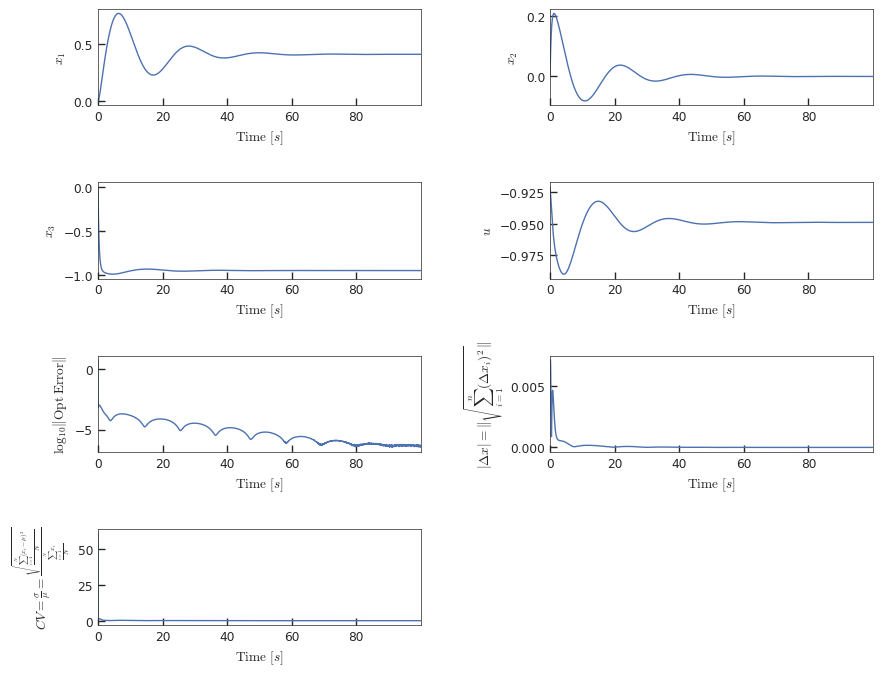

In [101]:
plotter = autogenu.Plotter(log_dir=ag.get_ocp_log_dir(), log_name=ag.get_ocp_name())
plotter.set_scales(2, 5, 2)
# plotter.show()
plotter.save()

## Draw animations of the simulation results


50


AttributeError: 'TrajectoryFollowing' object has no attribute '_TrajectoryFollowing__ground'

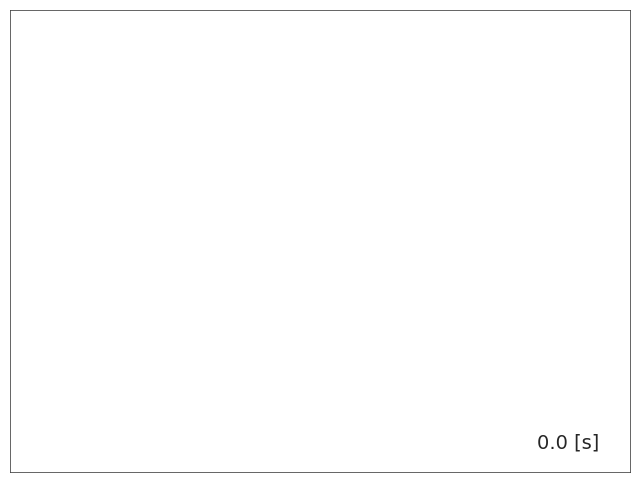

In [102]:
anim = autogenu.TrajectoryFollowing(
    log_dir=ag.get_ocp_log_dir(), log_name=ag.get_ocp_name()
)
anim.set_skip_frames(10)
anim.generate_animation()

## Build Python interface

- `generator`: An optional variable for Windows user to choose the generator of CMake. If 'MSYS', then 'MSYS Makefiles' is used. If 'MinGW', then 'MinGW Makefiles' is used. The default value is 'Auto' and the generator is selected automatically. If sh.exe exists in your PATH, MSYS is chosen, and otherwise MinGW is used.
- `vectorize` : If `True`, the vectorization, i.e., `-march=native` compile option is enabled. This can improve speed while can cause numerical issue depending on the compiler.
- `remove_build_dir`: If `True`, the existing build directory is removed. If `False`, the build directory is not removed. Need to be set `True` if you change the generator. Default is `False`.


In [ ]:
generator = "Auto"
vectorize = False
remove_build_dir = False
ag.generate_python_bindings()
ag.git_submodule_update()
ag.build_python_interface(
    generator=generator, vectorize=vectorize, remove_build_dir=remove_build_dir
)

## Install Python interface

- `install_prefix` : Prefix of the install destination of the python interfaces. Default is None.
  - If this is None (default), then it is `~/.local/lib/python3.x` (`python3.x` is your Python version).
    - If you use Ubuntu, `~/.local/lib/python3.x` is the default Python path, and you do not need to set `PYTHONPATH` additonally.
    - If you use MacOSX or Windows, add it to the Python PATH, as `export PYTHONPATH=$PYTHONPATH:$HOME/.local/lib/python3.x/site-packages`

The usage of Python interfaces is introduced in `examples/python` directory.


In [ ]:
ag.install_python_interface(install_prefix=None)

## Generate Documentation

The documentations for the generated code are available.  
`Doxygen` is required for the docs generation.


In [ ]:
# autogenu.generate_docs()
# autogenu.open_docs()